# Method 7 - Best Ideas High Popularity

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns from Intra-Cap Portfolio Weight per Shumway, Szefler, Yuan 2009

%store -r cap_exp_ret

valid_data = valid_data.merge(cap_exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Filter Popularity

best_ideas['port_tilt_pct'] = best_ideas.groupby('datadate')['adj_target'].rank(pct=True)

popularity = best_ideas.groupby(['datadate', 'fsym_id'])['port_tilt_pct'].sum().reset_index()
popularity['median_port_tilt_pct'] = popularity.groupby('datadate')['port_tilt_pct'].transform('median')
popularity = popularity[popularity['port_tilt_pct'] > popularity['median_port_tilt_pct']]

best_ideas = best_ideas.merge(popularity[['datadate', 'fsym_id', 'median_port_tilt_pct']])

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

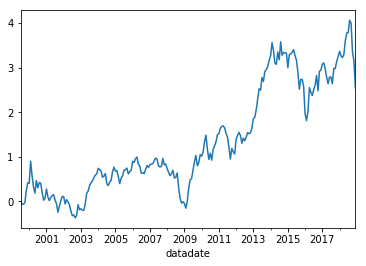

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.417230
2000-12-31   -0.248514
2001-12-31    0.042832
2002-12-31   -0.268840
2003-12-31    0.984967
2004-12-31    0.096294
2005-12-31   -0.037152
2006-12-31    0.035979
2007-12-31    0.044732
2008-12-31   -0.461495
2009-12-31    1.064615
2010-12-31    0.220156
2011-12-31   -0.174287
2012-12-31    0.280270
2013-12-31    0.577049
2014-12-31    0.038982
2015-12-31   -0.174248
2016-12-31    0.103833
2017-12-31    0.077155
2018-12-31   -0.165524
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     325.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.03e-93
Time:                        21:32:00   Log-Likelihood:                 455.16
No. Observations:                 234   AIC:                            -900.3
Df Residuals:                     229   BIC:                            -883.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0061      0.002      2.579      0.011       0.001       0.011
mktrf          0.9466      0.065     14.513      0.000       0.818       1.075
me             0.8964      0.076     11.815      0.000       0.747       1.046
ia            -0.0127      0.115     -0.110      0.913      -0.240       0.215
roe           -1.1290      0.099    -11.438      0.000      -1.323      -0.935
==============================================================================
Omnibus:                       70.868   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              254.331
Skew:                           1.216   Prob(JB):                     5.93e-56
Kurtosis:                       7.491   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     187.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.28e-71
Time:                        21:32:00   Log-Likelihood:                 455.16
No. Observations:                 234   AIC:                            -900.3
Df Residuals:                     229   BIC:                            -883.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0061      0.003      2.174      0.030       0.001       0.012
mktrf          0.9466      0.074     12.872      0.000       0.802       1.091
me             0.8964      0.120      7.493      0.000       0.662       1.131
ia            -0.0127      0.179     -0.071      0.944      -0.364       0.338
roe           -1.1290      0.189     -5.964      0.000      -1.500      -0.758
==============================================================================
Omnibus:                       70.868   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              254.331
Skew:                           1.216   Prob(JB):                     5.93e-56
Kurtosis:                       7.491   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     228.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.82e-79
Time:                        21:32:00   Log-Likelihood:                 455.16
No. Observations:                 234   AIC:                            -900.3
Df Residuals:                     229   BIC:                            -883.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0061      0.003      2.064      0.039       0.000       0.012
mktrf          0.9466      0.073     13.029      0.000       0.804       1.089
me             0.8964      0.135      6.626      0.000       0.631       1.162
ia            -0.0127      0.157     -0.080      0.936      -0.321       0.296
roe           -1.1290      0.204     -5.544      0.000      -1.528      -0.730
==============================================================================
Omnibus:                       70.868   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              254.331
Skew:                           1.216   Prob(JB):                     5.93e-56
Kurtosis:                       7.491   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     245.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.41e-89
Time:                        21:32:00   Log-Likelihood:                 449.51
No. Observations:                 234   AIC:                            -887.0
Df Residuals:                     228   BIC:                            -866.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0046      0.002      1.862      0.064      -0.000       0.010
mktrf          1.1153      0.067     16.623      0.000       0.983       1.248
smb            0.9478      0.089     10.706      0.000       0.773       1.122
hml           -0.1310      0.104     -1.255      0.211      -0.337       0.075
rmw           -0.9215      0.118     -7.808      0.000      -1.154      -0.689
cma            0.3189      0.150      2.126      0.035       0.023       0.615
==============================================================================
Omnibus:                       76.522   Durbin-Watson:                   1.857
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              252.077
Skew:                           1.360   Prob(JB):                     1.83e-55
Kurtosis:                       7.296   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     238.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.01e-88
Time:                        21:32:00   Log-Likelihood:                 449.51
No. Observations:                 234   AIC:                            -887.0
Df Residuals:                     228   BIC:                            -866.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0046      0.003      1.689      0.091      -0.001       0.010
mktrf          1.1153      0.063     17.652      0.000       0.991       1.239
smb            0.9478      0.110      8.618      0.000       0.732       1.163
hml           -0.1310      0.150     -0.874      0.382      -0.425       0.163
rmw           -0.9215      0.212     -4.343      0.000      -1.337      -0.506
cma            0.3189      0.227      1.406      0.160      -0.126       0.763
==============================================================================
Omnibus:                       76.522   Durbin-Watson:                   1.857
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              252.077
Skew:                           1.360   Prob(JB):                     1.83e-55
Kurtosis:                       7.296   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     340.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.38e-103
Time:                        21:32:00   Log-Likelihood:                 449.51
No. Observations:                 234   AIC:                            -887.0
Df Residuals:                     228   BIC:                            -866.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0046      0.003      1.572      0.116      -0.001       0.010
mktrf          1.1153      0.062     17.860      0.000       0.993       1.238
smb            0.9478      0.120      7.882      0.000       0.712       1.183
hml           -0.1310      0.132     -0.995      0.320      -0.389       0.127
rmw           -0.9215      0.241     -3.827      0.000      -1.393      -0.450
cma            0.3189      0.189      1.689      0.091      -0.051       0.689
==============================================================================
Omnibus:                       76.522   Durbin-Watson:                   1.857
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              252.077
Skew:                           1.360   Prob(JB):                     1.83e-55
Kurtosis:                       7.296   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     267.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.47e-85
Time:                        21:32:00   Log-Likelihood:                 435.70
No. Observations:                 234   AIC:                            -861.4
Df Residuals:                     229   BIC:                            -844.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.003      0.934      0.351      -0.003       0.007
mktrf          1.1706      0.065     17.938      0.000       1.042       1.299
smb            1.3492      0.081     16.563      0.000       1.189       1.510
hml           -0.1337      0.081     -1.652      0.100      -0.293       0.026
umd           -0.3009      0.053     -5.668      0.000      -0.406      -0.196
==============================================================================
Omnibus:                       73.035   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              298.319
Skew:                           1.207   Prob(JB):                     1.66e-65
Kurtosis:                       7.977   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     143.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.50e-61
Time:                        21:32:00   Log-Likelihood:                 435.70
No. Observations:                 234   AIC:                            -861.4
Df Residuals:                     229   BIC:                            -844.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.003      0.897      0.370      -0.003       0.008
mktrf          1.1706      0.059     19.970      0.000       1.056       1.285
smb            1.3492      0.106     12.748      0.000       1.142       1.557
hml           -0.1337      0.135     -0.992      0.321      -0.398       0.130
umd           -0.3009      0.106     -2.831      0.005      -0.509      -0.093
==============================================================================
Omnibus:                       73.035   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              298.319
Skew:                           1.207   Prob(JB):                     1.66e-65
Kurtosis:                       7.977   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     152.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.85e-63
Time:                        21:32:00   Log-Likelihood:                 435.70
No. Observations:                 234   AIC:                            -861.4
Df Residuals:                     229   BIC:                            -844.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.003      0.882      0.378      -0.003       0.008
mktrf          1.1706      0.054     21.698      0.000       1.065       1.276
smb            1.3492      0.108     12.469      0.000       1.137       1.561
hml           -0.1337      0.123     -1.085      0.278      -0.375       0.108
umd           -0.3009      0.116     -2.599      0.009      -0.528      -0.074
==============================================================================
Omnibus:                       73.035   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              298.319
Skew:                           1.207   Prob(JB):                     1.66e-65
Kurtosis:                       7.977   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     163.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.82e-46
Time:                        21:32:00   Log-Likelihood:                 211.18
No. Observations:                 120   AIC:                            -412.4
Df Residuals:                     115   BIC:                            -398.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0104      0.004      2.554      0.012       0.002       0.018
mktrf          0.9260      0.110      8.447      0.000       0.709       1.143
me             0.9295      0.108      8.584      0.000       0.715       1.144
ia            -0.0876      0.170     -0.517      0.606      -0.424       0.248
roe           -1.1288      0.150     -7.522      0.000      -1.426      -0.832
==============================================================================
Omnibus:                       30.611   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.166
Skew:                           1.022   Prob(JB):                     4.29e-15
Kurtosis:                       6.009   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     168.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.83e-47
Time:                        21:32:00   Log-Likelihood:                 211.18
No. Observations:                 120   AIC:                            -412.4
Df Residuals:                     115   BIC:                            -398.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0104      0.005      2.148      0.032       0.001       0.020
mktrf          0.9260      0.129      7.174      0.000       0.673       1.179
me             0.9295      0.161      5.756      0.000       0.613       1.246
ia            -0.0876      0.255     -0.344      0.731      -0.587       0.412
roe           -1.1288      0.280     -4.025      0.000      -1.679      -0.579
==============================================================================
Omnibus:                       30.611   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.166
Skew:                           1.022   Prob(JB):                     4.29e-15
Kurtosis:                       6.009   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     241.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.69e-55
Time:                        21:32:00   Log-Likelihood:                 211.18
No. Observations:                 120   AIC:                            -412.4
Df Residuals:                     115   BIC:                            -398.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0104      0.005      2.052      0.040       0.000       0.020
mktrf          0.9260      0.133      6.950      0.000       0.665       1.187
me             0.9295      0.184      5.060      0.000       0.569       1.289
ia            -0.0876      0.218     -0.403      0.687      -0.514       0.339
roe           -1.1288      0.308     -3.666      0.000      -1.732      -0.525
==============================================================================
Omnibus:                       30.611   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.166
Skew:                           1.022   Prob(JB):                     4.29e-15
Kurtosis:                       6.009   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     136.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.84e-46
Time:                        21:32:00   Log-Likelihood:                 213.92
No. Observations:                 120   AIC:                            -415.8
Df Residuals:                     114   BIC:                            -399.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0101      0.004      2.463      0.015       0.002       0.018
mktrf          1.2391      0.113     10.919      0.000       1.014       1.464
smb            1.0238      0.129      7.966      0.000       0.769       1.278
hml           -0.2990      0.157     -1.898      0.060      -0.611       0.013
rmw           -0.7373      0.186     -3.970      0.000      -1.105      -0.369
cma            0.4122      0.203      2.026      0.045       0.009       0.815
==============================================================================
Omnibus:                       30.329   Durbin-Watson:                   1.924
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.218
Skew:                           1.080   Prob(JB):                     3.76e-13
Kurtosis:                       5.604   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     187.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.16e-53
Time:                        21:32:00   Log-Likelihood:                 213.92
No. Observations:                 120   AIC:                            -415.8
Df Residuals:                     114   BIC:                            -399.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0101      0.005      2.178      0.029       0.001       0.019
mktrf          1.2391      0.116     10.665      0.000       1.011       1.467
smb            1.0238      0.163      6.280      0.000       0.704       1.343
hml           -0.2990      0.195     -1.533      0.125      -0.681       0.083
rmw           -0.7373      0.319     -2.311      0.021      -1.362      -0.112
cma            0.4122      0.269      1.533      0.125      -0.115       0.939
==============================================================================
Omnibus:                       30.329   Durbin-Watson:                   1.924
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.218
Skew:                           1.080   Prob(JB):                     3.76e-13
Kurtosis:                       5.604   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     330.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.48e-66
Time:                        21:32:00   Log-Likelihood:                 213.92
No. Observations:                 120   AIC:                            -415.8
Df Residuals:                     114   BIC:                            -399.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0101      0.005      2.004      0.045       0.000       0.020
mktrf          1.2391      0.112     11.021      0.000       1.019       1.460
smb            1.0238      0.179      5.723      0.000       0.673       1.374
hml           -0.2990      0.189     -1.583      0.113      -0.669       0.071
rmw           -0.7373      0.370     -1.993      0.046      -1.462      -0.012
cma            0.4122      0.210      1.966      0.049       0.001       0.823
==============================================================================
Omnibus:                       30.329   Durbin-Watson:                   1.924
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.218
Skew:                           1.080   Prob(JB):                     3.76e-13
Kurtosis:                       5.604   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     162.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.45e-46
Time:                        21:32:00   Log-Likelihood:                 210.86
No. Observations:                 120   AIC:                            -411.7
Df Residuals:                     115   BIC:                            -397.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0078      0.004      1.945      0.054      -0.000       0.016
mktrf          1.2254      0.097     12.655      0.000       1.034       1.417
smb            1.4013      0.110     12.710      0.000       1.183       1.620
hml           -0.2130      0.110     -1.928      0.056      -0.432       0.006
umd           -0.2990      0.068     -4.391      0.000      -0.434      -0.164
==============================================================================
Omnibus:                       36.127   Durbin-Watson:                   2.098
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               95.069
Skew:                           1.122   Prob(JB):                     2.27e-21
Kurtosis:                       6.739   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     112.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.95e-39
Time:                        21:32:00   Log-Likelihood:                 210.86
No. Observations:                 120   AIC:                            -411.7
Df Residuals:                     115   BIC:                            -397.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0078      0.004      2.033      0.042       0.000       0.015
mktrf          1.2254      0.077     15.853      0.000       1.074       1.377
smb            1.4013      0.114     12.273      0.000       1.178       1.625
hml           -0.2130      0.188     -1.135      0.256      -0.581       0.155
umd           -0.2990      0.114     -2.623      0.009      -0.522      -0.076
==============================================================================
Omnibus:                       36.127   Durbin-Watson:                   2.098
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               95.069
Skew:                           1.122   Prob(JB):                     2.27e-21
Kurtosis:                       6.739   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     127.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.55e-41
Time:                        21:32:00   Log-Likelihood:                 210.86
No. Observations:                 120   AIC:                            -411.7
Df Residuals:                     115   BIC:                            -397.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0078      0.004      2.088      0.037       0.000       0.015
mktrf          1.2254      0.070     17.620      0.000       1.089       1.362
smb            1.4013      0.114     12.258      0.000       1.177       1.625
hml           -0.2130      0.183     -1.166      0.243      -0.571       0.145
umd           -0.2990      0.124     -2.409      0.016      -0.542      -0.056
==============================================================================
Omnibus:                       36.127   Durbin-Watson:                   2.098
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               95.069
Skew:                           1.122   Prob(JB):                     2.27e-21
Kurtosis:                       6.739   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     179.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.02e-47
Time:                        21:32:00   Log-Likelihood:                 265.06
No. Observations:                 114   AIC:                            -520.1
Df Residuals:                     109   BIC:                            -506.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.002      0.294      0.770      -0.004       0.005
mktrf          1.0492      0.071     14.749      0.000       0.908       1.190
me             0.6799      0.110      6.191      0.000       0.462       0.898
ia             0.1457      0.152      0.956      0.341      -0.156       0.448
roe           -1.1307      0.134     -8.447      0.000      -1.396      -0.865
==============================================================================
Omnibus:                       16.277   Durbin-Watson:                   1.926
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.227
Skew:                           0.732   Prob(JB):                     1.49e-05
Kurtosis:                       4.592   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     471.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.89e-68
Time:                        21:32:00   Log-Likelihood:                 265.06
No. Observations:                 114   AIC:                            -520.1
Df Residuals:                     109   BIC:                            -506.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.002      0.372      0.710      -0.003       0.004
mktrf          1.0492      0.060     17.421      0.000       0.931       1.167
me             0.6799      0.095      7.193      0.000       0.495       0.865
ia             0.1457      0.155      0.942      0.346      -0.157       0.449
roe           -1.1307      0.223     -5.064      0.000      -1.568      -0.693
==============================================================================
Omnibus:                       16.277   Durbin-Watson:                   1.926
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.227
Skew:                           0.732   Prob(JB):                     1.49e-05
Kurtosis:                       4.592   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     1114.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.20e-87
Time:                        21:32:01   Log-Likelihood:                 265.06
No. Observations:                 114   AIC:                            -520.1
Df Residuals:                     109   BIC:                            -506.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.002      0.384      0.701      -0.003       0.004
mktrf          1.0492      0.046     22.852      0.000       0.959       1.139
me             0.6799      0.101      6.753      0.000       0.483       0.877
ia             0.1457      0.163      0.892      0.372      -0.174       0.466
roe           -1.1307      0.203     -5.570      0.000      -1.529      -0.733
==============================================================================
Omnibus:                       16.277   Durbin-Watson:                   1.926
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.227
Skew:                           0.732   Prob(JB):                     1.49e-05
Kurtosis:                       4.592   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     113.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.53e-41
Time:                        21:32:01   Log-Likelihood:                 254.15
No. Observations:                 114   AIC:                            -496.3
Df Residuals:                     108   BIC:                            -479.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.003     -0.623      0.535      -0.007       0.004
mktrf          1.1077      0.075     14.769      0.000       0.959       1.256
smb            0.7281      0.122      5.980      0.000       0.487       0.969
hml            0.1201      0.155      0.773      0.441      -0.188       0.428
rmw           -1.0134      0.190     -5.330      0.000      -1.390      -0.636
cma            0.1141      0.241      0.473      0.637      -0.364       0.593
==============================================================================
Omnibus:                       36.384   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              120.721
Skew:                           1.070   Prob(JB):                     6.11e-27
Kurtosis:                       7.564   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     136.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.73e-45
Time:                        21:32:01   Log-Likelihood:                 254.15
No. Observations:                 114   AIC:                            -496.3
Df Residuals:                     108   BIC:                            -479.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.002     -0.713      0.476      -0.006       0.003
mktrf          1.1077      0.067     16.419      0.000       0.975       1.240
smb            0.7281      0.116      6.253      0.000       0.500       0.956
hml            0.1201      0.110      1.089      0.276      -0.096       0.336
rmw           -1.0134      0.291     -3.485      0.000      -1.583      -0.443
cma            0.1141      0.215      0.531      0.595      -0.307       0.535
==============================================================================
Omnibus:                       36.384   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              120.721
Skew:                           1.070   Prob(JB):                     6.11e-27
Kurtosis:                       7.564   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     182.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.40e-51
Time:                        21:32:01   Log-Likelihood:                 254.15
No. Observations:                 114   AIC:                            -496.3
Df Residuals:                     108   BIC:                            -479.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.002     -0.805      0.421      -0.006       0.002
mktrf          1.1077      0.071     15.612      0.000       0.969       1.247
smb            0.7281      0.137      5.316      0.000       0.460       0.996
hml            0.1201      0.107      1.118      0.264      -0.090       0.331
rmw           -1.0134      0.319     -3.176      0.001      -1.639      -0.388
cma            0.1141      0.243      0.469      0.639      -0.363       0.591
==============================================================================
Omnibus:                       36.384   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              120.721
Skew:                           1.070   Prob(JB):                     6.11e-27
Kurtosis:                       7.564   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     111.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.62e-37
Time:                        21:32:01   Log-Likelihood:                 242.27
No. Observations:                 114   AIC:                            -474.5
Df Residuals:                     109   BIC:                            -460.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0028      0.003     -0.970      0.334      -0.009       0.003
mktrf          1.1566      0.082     14.050      0.000       0.993       1.320
smb            0.9520      0.128      7.417      0.000       0.698       1.206
hml            0.2590      0.132      1.959      0.053      -0.003       0.521
umd           -0.2045      0.100     -2.051      0.043      -0.402      -0.007
==============================================================================
Omnibus:                       38.658   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              143.621
Skew:                           1.100   Prob(JB):                     6.50e-32
Kurtosis:                       8.040   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     253.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.44e-54
Time:                        21:32:01   Log-Likelihood:                 242.27
No. Observations:                 114   AIC:                            -474.5
Df Residuals:                     109   BIC:                            -460.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0028      0.003     -1.115      0.265      -0.008       0.002
mktrf          1.1566      0.071     16.404      0.000       1.018       1.295
smb            0.9520      0.112      8.482      0.000       0.732       1.172
hml            0.2590      0.143      1.812      0.070      -0.021       0.539
umd           -0.2045      0.084     -2.438      0.015      -0.369      -0.040
==============================================================================
Omnibus:                       38.658   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              143.621
Skew:                           1.100   Prob(JB):                     6.50e-32
Kurtosis:                       8.040   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     342.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.12e-61
Time:                        21:32:01   Log-Likelihood:                 242.27
No. Observations:                 114   AIC:                            -474.5
Df Residuals:                     109   BIC:                            -460.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0028      0.003     -1.085      0.278      -0.008       0.002
mktrf          1.1566      0.069     16.795      0.000       1.022       1.292
smb            0.9520      0.088     10.778      0.000       0.779       1.125
hml            0.2590      0.131      1.972      0.049       0.002       0.516
umd           -0.2045      0.071     -2.867      0.004      -0.344      -0.065
==============================================================================
Omnibus:                       38.658   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              143.621
Skew:                           1.100   Prob(JB):                     6.50e-32
Kurtosis:                       8.040   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""